# Dealing with Images (Enhancing and Segmenting) [Notebook 3]

## Introduction

This project dives into Encoders-Decoders, where these models are used to edit and generate full images. How these models can be adapted for a wider range of applications such as image denoising or object and instance segmentation. The project will also introduce new concepts like Unpooling, Transposed and Atrous Convolutions layers to the network architecture and its utility for high-dimensional data. Encoders-Decoders can be used for semantic segmentation for driverless cars, where it would help in defining the objects surrounding the vehicle like, roads, other vehicles, people or trees etc. 

## Breakdown of this Project:
- Introduction to Encoders-Decoders. (Notebook 1)
- Encoders-Decoders trained for pixel-level prediction. (Notebook 1)
- Layers such as Unpooling, Transposed and Atrous Convolutions to output high-dimensional data. (Notebook 2)
- FCN and U-Net Architectures for semantic segmentation. (Notebook 3)
- Instance segmentation (extension of Faster-RCNN with Mask-RCNN) (Notebook 4)

## Requirements:
1) Tensorflow 2.0 (GPU prefferably) \
2) CV2 (OpenCV) \
3) Cython \
4) Eigen \
5) PyDenseCRF

For "PyDenseCRF" for windows, LINK: https://github.com/lucasb-eyer/pydensecrf\

It can be installed directly with the following in command prompt or terminal-equivalent: __conda install -c conda-forge pydensecrf__.

If Conda-Forge __does not work__, try: 
- going to: https://www.lfd.uci.edu/~gohlke/pythonlibs/#pydensecrf
- Download: pydensecrf-1.0rc2-cp37-cp37m-win_amd64.whl
- Where "cp37" in the filename is the python version of 3.7, make sure you download the correct one.
- Place the downloaded "pydensecrf-1.0rc2-cp37-cp37m-win_amd64.whl" file in your working directory drive.
- Open Command Prompt and type in: pip install pydensecrf-1.0rc2-cp37-cp37m-win_amd64.whl
- Or if you placed it in a folder or different location: pip install <FILEPATH>\pydensecrf-1.0rc2-cp37-cp37m-win_amd64.whl

## Dataset:
    
The dataset can be obtain from the link: https://www.cityscapes-dataset.com/dataset-overview/.

Quoted from the website: "The Cityscapes Dataset focuses on semantic understanding of urban street scenes." It consists of >5,000 images with fine-grained semantic labels, 20,000 images with coarser annotations that were shot from the view point of driving a car around different cities in Germany. 


### Import the required libraries:

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import math
import timeit
import time
import os
import matplotlib.pyplot as plt

# Run on GPU:
os.environ["CUDA_VISIBLE_DEVICES"]= "0" 
# tf.config.list_physical_devices('GPU')

D:\anaconda3\envs\Py37Work_TF2Alpha\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\envs\Py37Work_TF2Alpha\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\envs\Py37Work_TF2Alpha\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\envs\Py37Work_TF2Alpha\lib\site-packages\tensorflow\python\f

In [2]:
# Set the random set seed number: for reproducibility.
Seed_nb = 42

# Set to run or not run the code block: for code examples only. (0 = run code, and 1 = dont run code)
dont_run = 0

### GPU Information:

In [3]:
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# devices = sess.list_devices()
# devices

### Use RTX_GPU Tensor Cores for faster compute: FOR TENSORFLOW ONLY

Automatic Mixed Precision Training in TF. Requires NVIDIA DOCKER of TensorFlow.

Sources:
- https://developer.nvidia.com/automatic-mixed-precision
- https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html#framework

When enabled, automatic mixed precision will do two things:

- Insert the appropriate cast operations into your TensorFlow graph to use float16 execution and storage where appropriate(this enables the use of Tensor Cores along with memory storage and bandwidth savings). 
- Turn on automatic loss scaling inside the training Optimizer object.

In [4]:
# os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

EXAMPLE CODE: 

In [5]:
# # Graph-based example:
# opt = tf.train.AdamOptimizer()
# opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
# train_op = opt.miminize(loss)

# # Keras-based example:
# opt = tf.keras.optimizers.Adam()
# opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
# model.compile(loss=loss, optimizer=opt)
# model.fit(...)

### Use RTX_GPU Tensor Cores for faster compute: FOR KERAS API

Source:
- https://www.tensorflow.org/guide/keras/mixed_precision
- https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/experimental/Policy

In [6]:
# from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [7]:
# # Set for MIXED PRECISION:
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

### To run this notebook without errors, the GPU will have to be set accordingly:

In [8]:
# physical_devices = tf.config.list_physical_devices('GPU') 
# physical_devices
# tf.config.experimental.set_memory_growth(physical_devices[0], True) 

## 1 - What is Semantic Segmentation?:

__Semantic Segmentation__ is the task of segmenting images into meaningful parts, it covers segmentation of both objects and instances. This task is different comapred to image classification or object detection tasks, where more fundamentally, it requires the return of a pixel-level dense predictions whereby it assigns a label to each of the pixel of the input images.

## 2 - Encoders-Decoders for Object Segmentation:

Segmenting objects in a scene of an image can be described as the mapping of images from a colour domain to a class domain. It assigns one of the target classes to each pixel and returns a label map of the same height and width. To perform this kind of operation with an Encoder-Decoder will require further considerations as it is not as straightforward.

## 2.1 - Decoding as label maps:

If an Encoder-Decoder network was constructed to output label maps where each of the pixel value would be a class (i.e. 1 for house or 2 for car), the model would only output very poor results. A better implementation is to directly output categorical values instead. Previously, for the task of image classification that consist of "N" number of categories, the final layer of the network would outtput "N" logits for each class, these scores were then converted to probabilities with the Softmax function and finished by picking the largest probability value with Argmax function. This mechanism can also be applied to Semantic Segmentation, where it would be at a pixel level instead rather than the overall image level. 

##### The image below represents the task of Image Segmentation:

<img src="Description Images/Semantic_Segmentation_Overall.PNG" width="750">

The diagram above shows the process of the Encoder-Decoder model taking an input image and outputing the predicted label maps. This process can be broken into three parts. Note that the example used here is labeled as a low-resolution prediction map, where in practice, the predicted segmentation label map should have the same resolution as the original input.

##### The image below represents part 1 of Image Segmentation:

<img src="Description Images/Semantic_Segmentation_1.PNG" width="750">

Image Ref -> https://www.jeremyjordan.me/semantic-segmentation/

First, the main goal of the model would be to take an input such as a RGB coloured image tensor with the shape of (Height x Width x 3) or greyscale tensor with the shape of (Height x Width x 1), and to output a segmentation label map, where each of the pixel would have a class label that is represented as an integer (Height x Width x 1). 

##### The image below represents part 2 of Image Segmentation:

<img src="Description Images/Semantic_Segmentation_2.PNG" width="750">

Image Ref -> https://www.jeremyjordan.me/semantic-segmentation/

Second, the above shows an intermediate stage composing of individual masks for each of the class labels. By setting the number of output channels equal to the number of classes, the Encoder-Decoder model can obtain the output tensor. In doing so, it also means that it can be trained as a classifier. The loss is computed with cross-entropy loss, where it compares the softmax values with the one-hot-encoded ground truth label maps. These (Height x Width x N) prediction can be transformed into per-pixel labels by selecting the highest value along the channel axis. This essentially means that an output prediction image can be formed by collapsing the segmenation map by taking the argmax value along the channel axis (or depth-wise pixel vector).

##### The image below represents part 3 of Image Segmentation:

<img src="Description Images/Semantic_Segmentation_3.PNG" width="750">

Image Ref -> https://www.jeremyjordan.me/semantic-segmentation/

Third, by overlaying these predictions into a single channel will form the target prediction image, that is refered to as the __mask__, where each of the specific class is highlighted over regions of the image.





## 2.2 - Training the model with segmentation losses and metrics:

Utilising advanced architectures like FCN-8s or U-net can be advantageous for semantic segmentation as these are performant systerms. Like most models, these also require proper loss computations to converge optimally, however, even as cross-entropy loss was applied to train the models for both coarse and dense classifications, some precaution is needed for dense classification. 

One such precaution for this task is __class imbalance__. This is where the number of data (image) samples for one class is overwhelming more than another, and this will lead to a model that will always output a prediction of the class with the greater number. This of course is not an ideal model to have in practice. For image classification task, this can be avoided by simply removing or adding more data (images) so that all the classes will be in the same proportions. For pixel-level classification, the problem is different and can't be solved by simply adding or removing images. For example, some classes would appear in every image and spans only a few pizels, while the other classes would appear in more of the images (e.g. roads, cars etc). In these cases, the dataset itself can't be edited to improve the imbalance.

This fix this, the loss function requires some adaptation to account for the classes with larger numbers. In practice, this is done by including a weighing system on the contribution of each of the class to the cross-entropy loss computation. Meaning that, the less a class appearing in the training images, the more the weight is place on it in the loss computation, and consequently, the network would be heavily penalised if it begins to ignore smaller classes. The weight maps are derived from the ground truth label maps, where the weight that is applied to the pixel are set according to the class and also, according to the pixel's positioning that is relative to the other elements. 

Another fix for this problem, would be to replace the cross-entropy function altogether with another cost function. This removes the fact that it is affected by the proportions of the classes. One such function is the __Intersection-Over-Union (IoU) function__, or another is the __Sorensen-Dice Coefficient (Dice Coefficient)__. 

The __Jaccard Index__ or __Intersection over Union (IoU)__ is the common metric that is used to measure when a prediction and ground truth are matching. The following equation defines the IoU as:

$$ IoU(A, B) =  \frac{\lvert{A \cap B}\rvert}{\lvert{A \cup B}\rvert} = \frac {\lvert{A \cap B}\rvert}{\lvert{A}\rvert - \lvert{B}\rvert - \lvert{A \cap B}\rvert} $$

The __Sorensen-Dice Coefficient (Dice Coefficient)__ is a statistical gauge for the similarity between two image samples. It measures a range from 0 to 1, where 1 represents a perfect overlap between the two images. The following equation defines the Dice Coefficient as:

$$ Dice(A, B) =  \frac{2\lvert{A \cap B}\rvert}{\lvert{A}\rvert + \lvert{B}\rvert} $$

Where for both,
- $\lvert{A}\rvert$, is the cardinality of set A. The number of elements A contains.
- $\lvert{B}\rvert$, is the cardinality of set B. The number of elements B contains.
- $\lvert{A \cap B}\rvert$, is the numerator for number of elements that are in common between A and B. Here $A \cap B$ is the intersection between the two sets.
- $\lvert{A \cup B}\rvert$, is the demoninator for total number of elements that A and B sets covers. Here $A \cup B$ is the union of the sets.

Both __Intersection over Union (IoU)__ and __Sorensen-Dice Coefficient (Dice Coefficient)__ share several properties and is able to help compute one another. This can be seen with the equation below:

$$ IoU(A, B) = \frac{Dice(A, B)}{2 - Dice(A, B)} $$ and $$ Dice(A, B) = \frac{2 * IoU(A, B)}{1 + IoU(A, B)}$$

For a one class semantic segmentation, the __numerator__ for the Dice Coefficient is the number of correctly classified pixels, while the __denominator__ is the total number of pixels to belongs to this class in both the prediction and ground truth masks. 

As a metric, the Dice coefficient doesn't depend on the relative number of pixels that one class takes in the images. For multi-class tasks, the Dice coefficient is computed for each class, compared between each pair of predicted and ground truth masks, and then is averaged to get the results. 

As mentioned earlier, Dice coefficient measures a range from 0 to 1, where 1 represents a perfect overlap between the two images. But to use it as the loss function in a network (to minimise loss), the scoring is __reversed__. For semantic segmentation for "N" number of classes, the __Dice loss__ is then defined as the following:

$$ L_{Dice}(y, y^{true}) = 1 - \frac{1}{N}\sum^{N-1}_{k=0}Dice(y_{k}, y^{true}_{k}) $$ where $$ Dice(a, b) = \frac{\epsilon + 2\sum_{i, j}(a \odot b)_{i, j}}{\epsilon + \sum_{i, j}a_{i, j} + \sum_{i, j}b_{i, j}} $$

For two one-hot encoded tensor "a" and "b", the Dice numeratoris appoximated with applying an element-wise multiplication on both of them. These values are then summed together to form the resulting tensor. The denomiator is obtained by summing all the elements of "a" and "b". A small " $\epsilon$ " value is added to the denominator to avoid zero division while added to the numerator to smooth the result. This is termed as __Soft Dice__ Loss.

## 2.3 - Conditional Random Fields (CRFs) post-processing:

The task of labeling every pixel for segmentation is complex and usually yields poorly predicted label maps, where such maps would consists of poor contours and small incorrect areas. This where __Condition Random Fields (CRFs)__ comes in to help improve the results by post-processing them.

Generally, CRFs are able improves the pixel level predictions, by accounting for the context that was present in the original image. When there are no abrupt changes of colour or that the colour gradient between two neighbouring pixels are small, it means that they belong to the same class. The CRFs method therefore returns a refined label maps by combining the spatial and colour-based model along with probability maps from the predictors.

Here, the "pydensecrf" package will be used.

## 3 - Image Segmentation for Self-Driving Cars:

From the background introduction and model exercises (earlier notebooks) presented in previous sections, these will be apply onto __Segmentation of traffic images for Slef-driving cars__.

## 3.1 - The Task:

Applying semantic segmentation to video images obtained from camera systems would allow the vehicle to understand the environment and elements around them. It allows the vehicle to distinguish pedestrians, bikes, following traffic signs and lines and so on. The dataset used here would be the "Cityscapes" dataset.

## 3.2 - Implementation in TensorFlow:

The implementattion will be broken down into __three__ parts and are the following:
1) Setting up an Input Pipeline for the dataset. \
2) Implement FCN-8s model and apply it to the urban scenes. \
3) Implement U-Net model with CRFs for post-processing and apply it to the urban scenes.

## 4 - Setting up an Input Pipeline for the dataset:

### 4.1 - Installing the Dataset API:

Here, the dataset will be fetched and its API will be installed.

#### Step 1 -> Download the following zip files:

- leftImg8bit_trainvaltest.zip (11GB)
- gtFine_trainvaltest.zip (241mb)

These can be found in the link: https://www.cityscapes-dataset.com/downloads/
Note that this will require registration.

#### Step 2 -> Set up an environment vairable "CITYSCAPES_DATASET", that points to the folder consisting of the data:

In [9]:
currentDirectory = os.getcwd()
currentDirectory

# For PC:
# Run once, then comment it, so it does not execute the code again:
os.environ["CITYSCAPES_DATASET"] = currentDirectory + "/Dataset/cityscapes"

# For Mac:
# !export CITYSCAPES_DATASET= currentDirectory + "/Dataset/cityscapes"

In [10]:
# print(os.environ["CITYSCAPES_DATASET"])

#### Step 3 -> Unzip the files:

In [11]:
# Import the required modules:
from zipfile import ZipFile 

In [12]:
# For Mac:
# !cd currentDirectory + 'Dataset/cityscapes'
# !unzip leftImg8bit_trainvaltest.zip
# !unzip gtFine_trainvaltest.zip

In [13]:
# For PC: Expand-Archive
# Run once, then comment it, so it does not execute the code again:

# Specifying the zip file name:
# file_name = currentDirectory + "/Dataset/cityscapes/" + "leftImg8bit_trainvaltest.zip"
# file_name2 = currentDirectory + "/Dataset/cityscapes/" + "gtFine_trainvaltest.zip"
# file_name3 = currentDirectory + "/Dataset/cityscapes/" + "leftImg8bit_blurred.zip"

# # Opening the zip file in READ mode:
# with ZipFile(file_name, 'r') as zip:  
#     # extracting all the files 
#     print('Extracting all the files now...') 
#     zip.extractall() 
#     print('Done!') 

In [14]:
# with ZipFile(file_name2, 'r') as zip:  
#     # extracting all the files 
#     print('Extracting all the files now...') 
#     zip.extractall() 
#     print('Done!') 

In [15]:
# with ZipFile(file_name3, 'r') as zip:  
#     # extracting all the files 
#     print('Extracting all the files now...') 
#     zip.extractall() 
#     print('Done!') 

Check the location of the extracted files. They may require moving back to the "dataset" folder.

#### Step 4 -> Next, is to clone the Github repositor:

This contains the scripts to handle the datasets. Link: https://github.com/mcordts/cityscapesScripts

In [16]:
# !git clone https://github.com/mcordts/cityscapesScripts.git

#### Step 5 -> Compile the scripts with the "pip" command:

In [17]:
# # For Mac:
# !cd currentDirectory + "/cityscapesScripts"
# !pip install .

# # For PC:
# os.chdir(currentDirectory + "\cityscapesScripts")
# !pip install .

With the above steps completed, the Cityscapes API can be used by importing the "cutyscapesscripts" Python module.

#### Step 6 -> Transform the ".json" file of semantic annotations into the required mask images:

Convert annotations in polygonal format to png images with label IDs. To do this, use the following commands. Note that the files will be stored in the same folder.

In [18]:
# !csCreateTrainIdLabelImgs

### 4.2 - Explore the CityScapes Dataset:

#### 4.2.1 - Classes:

With the dataset download and accessible, the next stage is to explore the data. Note that the API have helper functions to define the labels and structure.

In [19]:
# Import the cityscapes module:
import cityscapesscripts.helpers.labels as cityscapes_labels

In [20]:
# Define the tabular format:
table_format = '| {0: >2} | {1: <20} | {2: >7} | {3: >15} | {4: <12} | {5: >5} |'

# print out the table and inspect the label data:
header = table_format.format("id", "name", "trainId", "colour", "category", "catId")
print(header)
print("-" * len(header))

for label in cityscapes_labels.labels:
    print(table_format.format(label.id, label.name, label.trainId, str(label.color), label.category, label.categoryId))

| id | name                 | trainId |          colour | category     | catId |
--------------------------------------------------------------------------------
|  0 | unlabeled            |     255 |       (0, 0, 0) | void         |     0 |
|  1 | ego vehicle          |     255 |       (0, 0, 0) | void         |     0 |
|  2 | rectification border |     255 |       (0, 0, 0) | void         |     0 |
|  3 | out of roi           |     255 |       (0, 0, 0) | void         |     0 |
|  4 | static               |     255 |       (0, 0, 0) | void         |     0 |
|  5 | dynamic              |     255 |    (111, 74, 0) | void         |     0 |
|  6 | ground               |     255 |     (81, 0, 81) | void         |     0 |
|  7 | road                 |       0 |  (128, 64, 128) | flat         |     1 |
|  8 | sidewalk             |       1 |  (244, 35, 232) | flat         |     1 |
|  9 | parking              |     255 | (250, 170, 160) | flat         |     1 |
| 10 | rail track           

From the output table above, the dataset can be seen to consist of 34 classes, where each of these classes have trainId, colour (color), category and catId. 

Taking a closer look at the trainId, note there are repeats of the value 255 and even a -1. According to the authors, these are classes that are not included in any evaluation and should be treated as void. Therefore these classes will be ignored forexperimentations.

To keep only the data of interest, a filter of the folowing will be needed:
- trainId > 0
- trainId != 255

In [21]:
# Define the condition or value to ignore in the dataset:
value_to_ignore = 255

# Filter these out:
CITYSCAPES_LABELS = [label for label in cityscapes_labels.labels 
                     if 0 <= label.trainId < value_to_ignore]

Once the filters have been applied, check out the dataset again.

In [22]:
# Define the tabular format:
table_format = '| {0: >7} | {1: <20} | {2: >15} |'

# print out the table and inspect the label data:
header = table_format.format("trainId", "name", "colour")
print(header)
print("-" * len(header))

for label in CITYSCAPES_LABELS:
    print(table_format.format(label.trainId, label.name, str(label.color)))

| trainId | name                 |          colour |
----------------------------------------------------
|       0 | road                 |  (128, 64, 128) |
|       1 | sidewalk             |  (244, 35, 232) |
|       2 | building             |    (70, 70, 70) |
|       3 | wall                 | (102, 102, 156) |
|       4 | fence                | (190, 153, 153) |
|       5 | pole                 | (153, 153, 153) |
|       6 | traffic light        |  (250, 170, 30) |
|       7 | traffic sign         |   (220, 220, 0) |
|       8 | vegetation           |  (107, 142, 35) |
|       9 | terrain              | (152, 251, 152) |
|      10 | sky                  |  (70, 130, 180) |
|      11 | person               |   (220, 20, 60) |
|      12 | rider                |     (255, 0, 0) |
|      13 | car                  |     (0, 0, 142) |
|      14 | truck                |      (0, 0, 70) |
|      15 | bus                  |    (0, 60, 100) |
|      16 | train                |    (0, 80, 

As it can be seen, the dataset now is left with only __19__ classes for pixel-level classification.

#### 4.2.2 - Visualise the Images in the Dataset:

Here, the images will be visualised according to the label maps.

Before getting started, some helper variables will be defined to be used later on.

In [23]:
# Extract the list of colours for the 19 classes:
CITYSCAPES_COLOURS = np.array( [label.color for label in CITYSCAPES_LABELS] )

# Set the Dataset Folder:
CITYSCAPES_FOLDER = os.getenv('CITYSCAPES_DATASET', default=os.path.expanduser('~/Dataset/cityscapes'))

Next, define a function to help list out all the images with their corresponding labels.

In [24]:
# Import the required library:
import glob

In [25]:
# Define the file template:
CITYSCAPES_FILE_TEMPLATE = os.path.join('{root}', '{type}', '{split}', '{city}', 
                                        '{city}_{seq:{filler}>{len_fill}}_{frame:{filler}>{len_fill}}_{type}{type2}{ext}')

In [26]:
def extract_cityscapes_file_pairs(split='train', city="*", sequence='*', frame='*', ext='.*',
                                  gt_type='labelTrainIds', type='leftImg8bit',
                                  root_folder=CITYSCAPES_FOLDER, file_template=CITYSCAPES_FILE_TEMPLATE):
    """ This builds a function to Extract the filenames for the CityScapes Dataset
        Note: to account for wildcards in the parameters, city='*' is set, to return
              image paris from every city.
        Parameters:
            - split, is the name of the split to return pairs from ("train" or "val").
            - city, is the name of the City or Cities.
            - sequence, is the name of the video sequence(s).
            - frame, is the frame.
            - ext, is the extension.
            - gt_type, is the Cityscapes GT type.
            - type, is ht eCityscapes image type.
            - root_folder, is the Cityscapes root folder.
            - file_template, is the file template to be applied (where default = corresponds to Cityscapes original format)
        Returns:
            - returns a List of input files, List of corresponding GT files.
    """
    input_file_template = file_template.format(root=root_folder, type=type, type2='',
                                              len_fill=1, filler='*', split=split, city=city,
                                              seq=sequence, frame=frame, ext=ext)
    input_files = glob.glob(input_file_template)
    
    gt_file_template = file_template.format(root=root_folder, type='gtFine', type2='_'+gt_type,
                                            len_fill=1, filler='*', split=split, city=city, 
                                            seq=sequence, frame=frame, ext=ext)
    gt_files = glob.glob(gt_file_template)
    
    assert( len(input_files) == len(gt_files) )
    return sorted(input_files), sorted(gt_files)

##### Note: For the purpose of privacy, the "leftImg8bit_blurred" zip file was also downloaded and extracted.

These blurred images will be utilised to ensure the privacy of the people in these images.

#### Extract the Data Pairs:

FileNames are:
- gtFine
- leftImg8bit
- leftImg8bit_blurred

In [27]:
# Training Dataset:
# train_input_files, train_gt_files = extract_cityscapes_file_pairs(split='train', 
#                                                                    type='leftImg8bit')

train_input_files, train_gt_files = extract_cityscapes_file_pairs(split='train', 
                                                                   type='leftImg8bit_blurred')

# Validation Dataset:
# val_input_files, val_gt_files = extract_cityscapes_file_pairs(split='val', 
#                                                               type='leftImg8bit')

val_input_files, val_gt_files = extract_cityscapes_file_pairs(split='val', 
                                                              type='leftImg8bit_blurred')

# Print out the number of data samples and gts:
print("Cityscapes - Training Dataset : {} images ; {} GTs.".format(len(train_input_files), 
                                                                   len(train_gt_files)))

print("Cityscapes - Validation Dataset : {} images ; {} GTs.".format(len(val_input_files), 
                                                                     len(val_gt_files)))

Cityscapes - Training Dataset : 2975 images ; 2975 GTs.
Cityscapes - Validation Dataset : 500 images ; 500 GTs.


#### Visualise:

After having access to the data pairs (above), the next stage would be to visualise them. To do this, a function is needed to convert the label maps, that are 2D tensors that contains the "trainID" value for each of the pixel, into colour images.

In [28]:
def convert_labels_to_colours_numpy(label, one_hot=True, nb_classes=len(CITYSCAPES_LABELS),
                                    colour_array=CITYSCAPES_COLOURS, ignore_value=value_to_ignore):
    """ This Covnerts the Label Images into coloured ones for display. These will be Numpy Objects.
    Parameters:
        - label, is the Label image (in Numpy Arrays).
        - one_hot, is an optional Flag to one-hot-encode the label image, if they weren't beforehand.
        - nb_classes, is the number of classses for one-hot-encoding.
        - colour_array, is the Array mapping the labels to colours.
        - ignore_value, is the value of the label to be ignored (value_to_ignore) for one-hot-encoding.
    Returns:
        - returns a Colour Map.
    """
    if one_hot:
        label_shape = label.shape
        label = label.reshape(-1)
        
        label[label == ignore_value] = nb_classes
        label = np.eye(N = nb_classes + 1, 
                       dtype=np.int32)[label]
        
#         label = np.eye(N = nb_classes + 1, 
#                        dtype=np.float32)[label]
        
        label = label[..., :nb_classes]
    
    else:
        label_shape = label.shape[:-1]
        label = label.reshape(-1, label.shape[-1])
        
    colours = np.matmul(label, colour_array)
    
    return colours.reshape(list(label_shape) + [colours.shape[1]])
    

In [29]:
# Import the required libraries:
import skimage.io as io
import matplotlib.pyplot as plt
from plotting_utilities import plot_images_inGrid

D:\anaconda3\envs\Py37Work_TF2Alpha\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


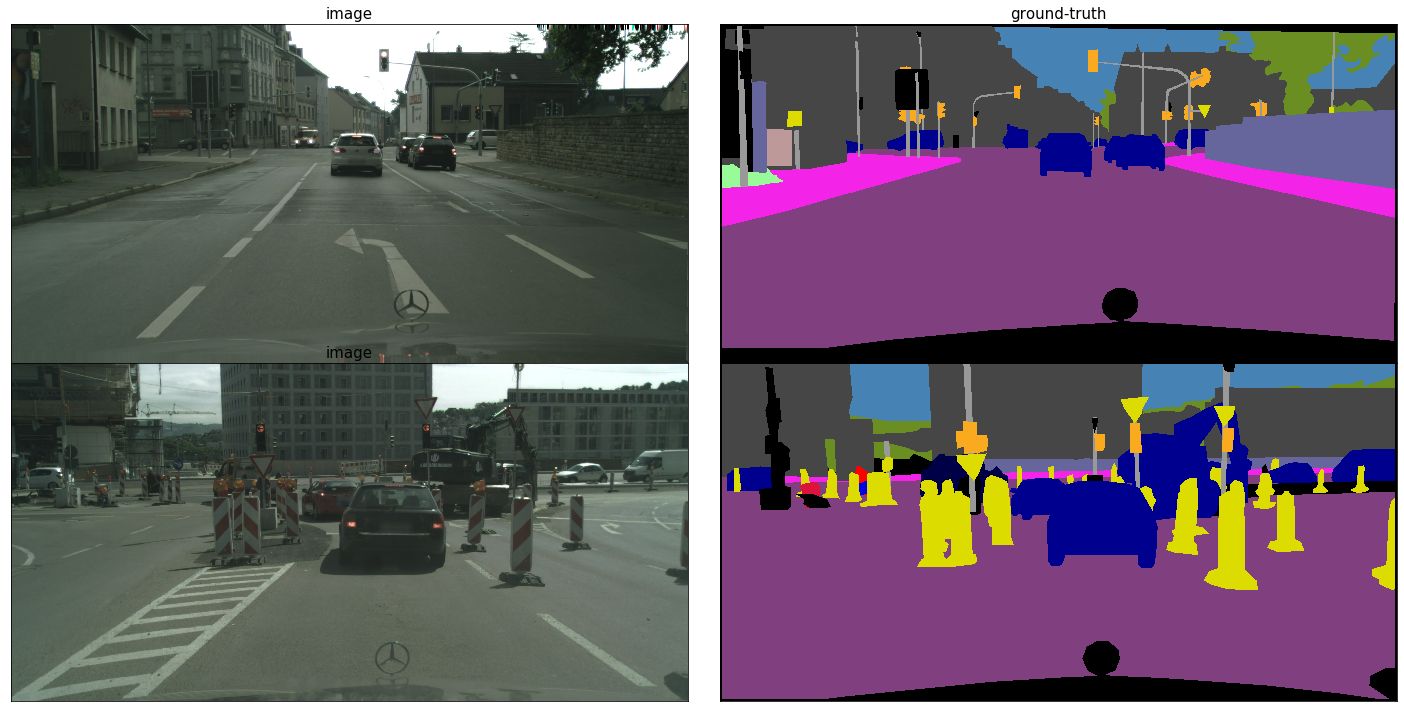

In [30]:
# Define the number of images to show:
nb_show = 2

random_ids = np.random.choice(len(train_input_files), size = nb_show)

# Take the image samples:
train_input_files_samples = [train_input_files[i] for i in random_ids]
train_gt_files_samples = [train_gt_files[i] for i in random_ids]

images_samples = [io.imread(file) for file in train_input_files_samples]
gt_samples = [io.imread(file) for file in train_gt_files_samples]
gt_colours = [convert_labels_to_colours_numpy(label = mask) for mask in gt_samples]

# Plot:
fig = plot_images_inGrid(images=[images_samples, gt_colours], titles=["image", 'ground-truth'])
fig.show()

### Observation:


## 5 - Setting up the Input Pipeline:

Here, "tf.data" API will be used to build the input pipeline for serving the training and validation batches to the models.

### 5.1 - Image Parsing and Augmentation:

There will be some defined TensorFlow-based Functions here to parse thse images and label files to convert them into proper tensors as well as the option to augment the data.

As the FCN-8s is based on the VGG-16 model that utilises 224x224 images (square images), the ratio of the images will be changed to be square as well. A scaler (done by saving the original ratio/shape) will be used to scale the predictions back to the original shape in the post-processing stage. 

In [31]:
images = images_samples

# Define the Image Ratio fro Scaling in Post-Processing:
CITYSCAPES_IMG_RATIO = int(images[0].shape[1] / int(images[0].shape[0]))

print("Cityscape image shape = {} --> ratio = {} (to reshape squared images later)".format(
    images[0].shape, CITYSCAPES_IMG_RATIO))

Cityscape image shape = (1024, 2048, 3) --> ratio = 2 (to reshape squared images later)


#### Function to parse the pairs of filenames that is yielded by the data pipeline into tensors:

In [32]:
def parse_func(filenames, resize_to=[226, 226], augment=True):
    """ This Parses the files into input/label image pair.
    Parameters:
        - filenames, is the Dict that contains the file(s). (filenames['image'], filenames['label'])
        - resize_to, is the Height x Width Dimensions to resize the image and label into.
        - augment, is an optional Flag to augment the data pairs.
    Returns:
        - returns an Input tensor, Label tensor.
    """
    # Get the image and label filenames:
    img_filename, gt_filename = filenames['image'], filenames.get('label', None)
    
    # Read the file and return as Bytes:
    image_string = tf.io.read_file(img_filename)
    
    # Decode the data into an Image:
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)
    
    # Convert the image to Float:
    image = tf.image.convert_image_dtype(image_decoded, tf.float32)
    
    # Resize the image:
    image = tf.image.resize(image, resize_to)
    
    # Apply the same as above to the Labels:
    if gt_filename is not None:
        gt_string = tf.io.read_file(gt_filename)
        gt_decoded = tf.io.decode_png(gt_string, channels=1)
        gt = tf.cast(gt_decoded, dtype=tf.int32)
#         gt = tf.cast(gt_decoded, dtype=tf.float32)
        gt = tf.image.resize(gt, resize_to, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
        # Augmenting: if True
        if augment:
            image, gt = _augmenation_func(image, gt)
        return image, gt
    
    else:
        if augment:
            image = _augmenation_func(image)
        return image


#### Augmentation of the data, Applying several random transformations:

The following will be functions to be used in the input pipeline to apply:
- Data Augmentation
- Random Ttransformations (like random colour/brightness changes, random horizontal flip, random cropping/scaling and so on.)

Note, there will be some care into applying these transformations to both the input image and the target label map, such as if flipping or crop the image is done, the same would be applied to the label map to keep things consistent.

In [33]:
def _augmenation_func(image, gt_image=None):
    """ This builds a function to apply random transforamtion to augment the training images.
    Parameters:
        - images, is the input images.
    Returns:
        - returns Augmented Images.
    Note:
        To randomly flip or crop the images, will require the same to be applied to the label for
        consistency.
    """
    original_shape = tf.shape(image)[-3:-1]
    nb_image_chnls = tf.shape(image)[-1]
    
    # Stack the image and label together along the channel axis for the random operations
    # (flip or resize/crop) to be applied to both:
    if gt_image is None:
        stacked_images = image
        nb_stacked_chnls = nb_image_chnls
    else:
        stacked_images = tf.concat([image, tf.cast(gt_image, dtype=image.dtype)], axis=-1)
        nb_stacked_chnls = tf.shape(stacked_images)[-1]
        
    # Apply random horizontal flip:
    stacked_images = tf.image.random_flip_left_right(stacked_images)
    
    # Apply random cropping:
    random_scale_factor = tf.random.uniform([], minval=.8, maxval=1., dtype=tf.float32)
    crop_shape = tf.cast(tf.cast(original_shape, tf.float32) * random_scale_factor, tf.int32)
    
    if len(stacked_images.shape) == 3:
        # For a singel images:
        crop_shape = tf.concat([crop_shape, [nb_stacked_chnls]], axis = 0)
    else:
        # for batched images:
        batch_size = tf.shape(stacked_images)[0]
        crop_shape = tf.concat([[batch_size], crop_shape, [nb_stacked_chnls]], axis = 0)
    stacked_images = tf.image.random_crop(stacked_images, crop_shape)
    
    # The following transformations will be applied differently to the input and gt images
    # (nearest-neighbor resizing for the label image VS interpolated resizing for the image),
    # or applied only to the input image. Hence, split them back:
    image = stacked_images[..., :nb_image_chnls]
    
    # Resize the image back to the expected dimensions:
    image = tf.image.resize(image, original_shape)
    
    # Apply random Brightness/Saturation changes:
    image = tf.image.random_brightness(image, max_delta=0.15)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.75)
    image = tf.clip_by_value(image, 0.0, 1.0) # to keep pixel values in check.
    
    if gt_image is not None:
        gt_image = tf.cast(stacked_images[..., nb_image_chnls:], dtype=gt_image.dtype)
        gt_image = tf.image.resize(gt_image, original_shape, method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        
        return image, gt_image
    else:
        return image        
    

#### Complete by putting everything together:

Here, the functions above will be wrapped into an input function to be called to instantiate the data pipeline.

In [34]:
# Import the required library:
import functools

In [35]:
def segmentation_input_func(image_files, gt_files=None, resize=[256, 256], shuffle=False, 
                            batch_size=32, nb_epochs=None, augment=False, seed=None):
    """ This is the Input Data Pipeline for Semantic Segmentation applications.
    Parmeters:
        - image_files, is the List of input image files.
        - gt_files, is an optional List of corresponding label image files.
        - resize_to, is the Heigh x Width dimensions for resizing the image and label.
        - shuffle, is a Flag to shuffle the dataset.
        - batch_size, is the batch size.
        - nb_epochs, is the number of epochs the dataset will be iterated over.
        - augment, is an optional Flag to augment the image pairs.
        - seed, is an optional Flag to set the seed for reproducibility purposes.
    Returns:
        - returns tf.data.Dataset
    
    """
    # Convertting to TensorFlow Dataset format:
    image_files = tf.constant(image_files)
    data_dict = {'image': image_files}
    
    if gt_files is not None:
        gt_files = tf.constant(gt_files)
        data_dict['label'] = gt_files
    
    # Get the slices of an array in the form of objects (Dict):
    dataset = tf.data.Dataset.from_tensor_slices(data_dict)
    
    # If Shuffle is set to True:
    if shuffle:
        dataset = dataset.shuffle(buffer_size = 1000, seed= seed)
    dataset = dataset.prefetch(1)
    
    # Batching and Adding the Parsing Operation:
    parse_fn = functools.partial(parse_func, resize_to=resize, augment=augment)
    dataset = dataset.map(parse_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    
    dataset = dataset.repeat(nb_epochs)
    
    return dataset   
    

In [36]:
def cityscapes_input_func(split='train', root_folder=CITYSCAPES_FOLDER, resize_to=[256, 256], shuffle=False,
                          batch_size=32, nb_epochs=None, augment=False, seed=None, blurred=False):
    """ This sets up the Input Data Pipeline for Semantic Segmentation applications for
        the Dataset -> Cityscapes dataset.
    Parameters:
        - split, is the Split name such as ('train', 'val', 'test')
        - root_folder, is the Cityscapes root folder.
        - resize_to, is the Height x Width dimensions to resize the image and label.
        - shuffle, is an optional Flag to shuffle the dataset.
        - batch_size, is the Batch size.
        - nb_epochs, is the number of epochs that the dataset would be iterated over.
        - augment, is the Flag to augment the image pairs.
        - seed, is an optional Flag to set the seed for reproducibility purposes.
        - blurred, is the FLag to use images with faces and immatriculation plates blurred
                   (for display).
    Returns:
        - returns tf.data.Dataset
    """
    # Set up the dataset type: blurred or not.
    type = "leftImg8bit_blurred" if blurred else "leftImg8bit"

    # Process the files:
    input_files, gt_files = extract_cityscapes_file_pairs(split=split,
                                                          type=type,
                                                          root_folder=root_folder)

    return segmentation_input_func(image_files=input_files,
                                   gt_files=gt_files,
                                   resize = resize_to,
                                   shuffle=shuffle,
                                   batch_size=batch_size,
                                   nb_epochs=nb_epochs,
                                   augment=augment,
                                   seed=seed)


##### Below shows an example on calling the above methods:

In [37]:
# Define the parameters:
batch_size = 16
nb_epochs = 50
image_size = [512, 512]

# Extract and Process the dataset:
train_dataset = segmentation_input_func(image_files=train_input_files_samples, 
                                        gt_files=train_gt_files_samples, 
                                        resize=image_size, 
                                        batch_size=batch_size,
                                        shuffle=True, 
                                        nb_epochs= nb_epochs, 
                                        augment=True)

val_dataset = segmentation_input_func(image_files=val_input_files, 
                                      gt_files=val_gt_files, 
                                      resize=image_size, 
                                      batch_size=batch_size,
                                      shuffle=False, 
                                      nb_epochs= nb_epochs, 
                                      augment=False)

In [38]:
train_dataset

<RepeatDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.int32)>

In [39]:
val_dataset

<RepeatDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 1)), types: (tf.float32, tf.int32)>

In [40]:
# print(len(train_dataset))
# print(len(val_dataset))

### 5.2 - Data Visualisation Tools:

Here, more helper functions/methods will be defined to post-process the results. These will be used for visualising the results.

In [41]:
# Define a Constant Tensorflow variable for the Colours:
CITYSCAPES_COLOURS_TF = tf.constant(CITYSCAPES_COLOURS, dtype=tf.int32)

In [42]:
def change_ratio(image=None, pred=None, gt=None, ratio=CITYSCAPES_IMG_RATIO):
    """ This builds a function to Resize the Images to the appropriate defined ratios.
    Parameters:
        - image, is an optional Input Image.
        - pred, is an optional Predicted label image.
        - gt, is an optional Target Image.
        - ratio, is the defined ratio to be set for the images.
    Returns:
        - returns the 3 resized images.
    """
    # Check and set the input:
    valid_input = image if image is not None else pred if pred is not None else gt
    
    # Define the current size of the input:
    current_size = tf.shape(valid_input)[-3:-1]
    
    # Define the width * ratio:
    width_with_ratio = tf.cast(tf.cast(current_size[1], tf.float32) * ratio, tf.int32)
    
    # stack the size with the width_with_ratio:
    size_with_ratio = tf.stack([current_size[0], width_with_ratio], axis=0)
    
    if image is not None:
        image = tf.image.resize(images = image, 
                                size = size_with_ratio)
        
    if pred is not None:
        pred = tf.image.resize(images=pred, 
                               size=size_with_ratio, 
                               method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    if gt is not None:
        gt = tf.image.resize(images= gt,
                             size= size_with_ratio,
                             method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return image, pred, gt

In [43]:
def convert_label_to_colours(label, one_hot=True, nb_classes=len(CITYSCAPES_LABELS),
                             colour_tensor=CITYSCAPES_COLOURS_TF):
    """ This converts the Label images into Coloured ones, for the purposes of displaying thm.
    Paramters:
        - label, is the Label Image (tensor).
        - one_hot, is the Flag to one-hot encode the label images if they are not encoded.
        - nb_classes, is the number of classes for one-hot-encoding.
        - colour_tensor, is the TTensor mapping labels to colours.
    Returns:
        - returns the Colour Map.
    """
    # Define the shape and channels:
    label_shape = tf.shape(label)
    colour_channels = tf.shape(colour_tensor)[-1]
    
    # Check to one-hot encode the label:
    if one_hot:
        label = tf.one_hot(label, nb_classes)
    else:
        label_shape = label_shape[:-1]
    
    # Return the labels as coloured ones:
    label = tf.reshape(tf.cast(label, tf.int32), (-1, nb_classes))
    colours= tf.matmul(label, colour_tensor)
    
    return tf.reshape(colours, tf.concat( [label_shape, [colour_channels]] , axis = 0))   
    
    

In [44]:
def postprocess_to_show_images(image=None, pred=None, gt=None, one_hot=True, ratio=CITYSCAPES_IMG_RATIO):
    """ This post-processes the training results of the segmentation model for display. 
        The training results should be tensors.
    Parameters:
        - image, is an optional Input image tensor.
        - pred, is an optional Predicted label map tensor.
        - gt, is an optional target label map tensor.
        - one_hot, is the Flag to one-hot-encode the label images if they were not done yet.
        - ratio, is the Original image ratios.
    Returns:
        - returns the processed image tensor(s).
    """
    # Define a list to store the output:
    out = []
    
    # Apply a change of ratios to the images:
    image_show, pred_show, gt_show = change_ratio(image, pred, gt, ratio)
    
    # Update the Output list:
    if image is not None:
        out.append(image_show)
    
    if pred is not None:
        if one_hot:
            # Remove the unnecessary channel dimensions:
            pred_show = tf.squeeze(pred_show, -1)
        pred_show = convert_label_to_colours(pred_show, one_hot=one_hot)
        out.append(pred_show)
        
    if gt is not None:
        # Remove the unnecessary channel dimensions:
        gt_show = tf.squeeze(gt_show, -1)
        gt_show = convert_label_to_colours(gt_show)
        out.append(gt_show)
        
    return out if len(out) > 1 else out[0]
    

##### With the above functions defined, next is to test the functions/methods to visualise some of the augmented images from the training set:

D:\anaconda3\envs\Py37Work_TF2Alpha\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


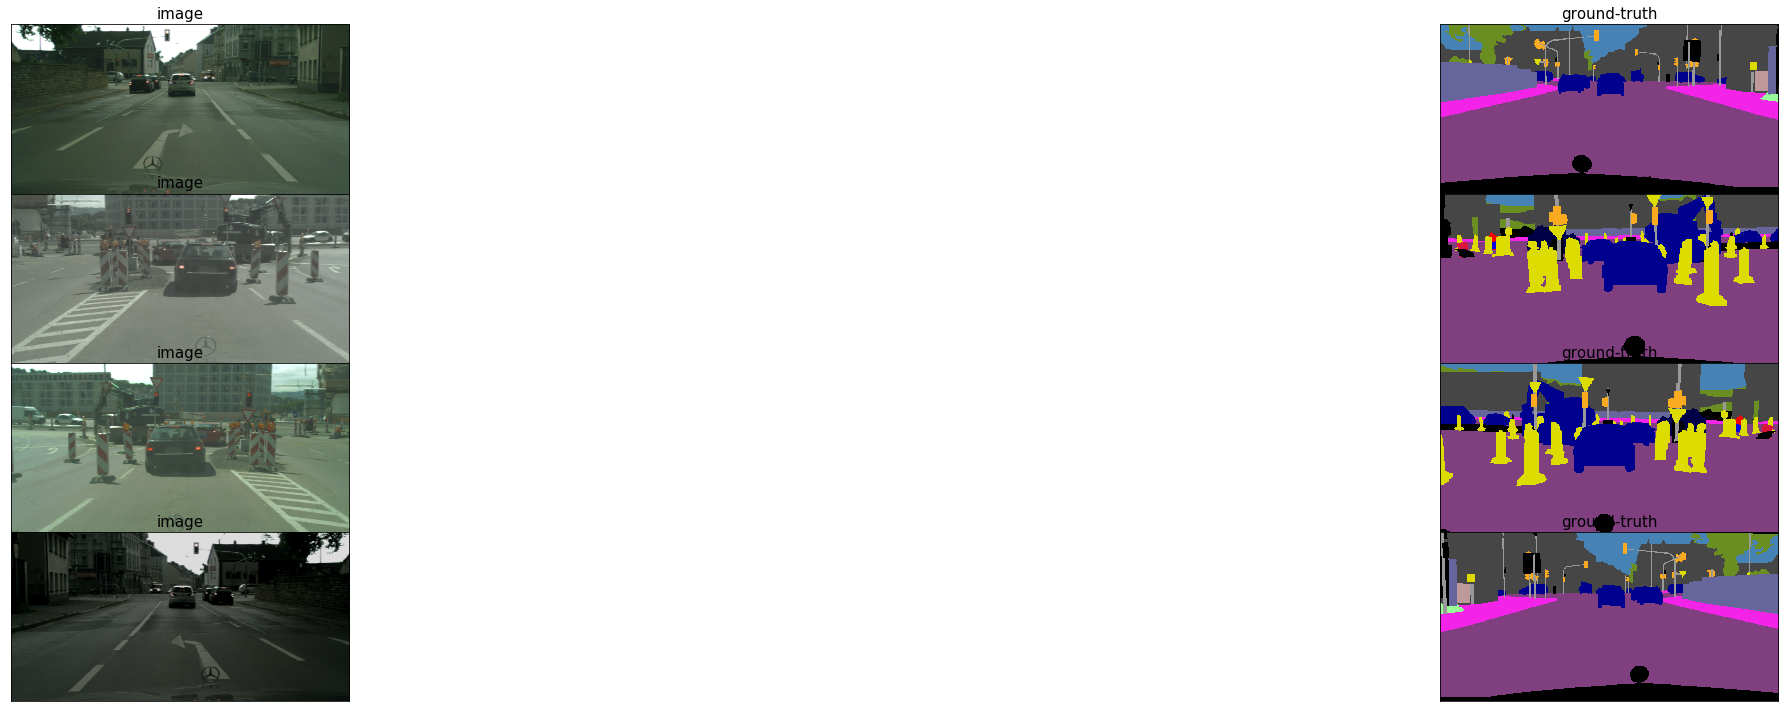

In [45]:
# Define the Number of images to show:
nb_show = 2

train_dataset_iter = train_dataset.__iter__()

# Select the images:
train_images1, train_labels1 =  next(train_dataset_iter)
train_images2, train_labels2 =  next(train_dataset_iter)

# Concatenate the images and label separately:
train_images = np.concatenate((train_images1[:nb_show], train_images2[:nb_show]), axis=0)
train_labels = np.concatenate((train_labels1[:nb_show], train_labels2[:nb_show]), axis=0)

# Post process these images:
image_show, gt_show = postprocess_to_show_images(image=train_images, pred=train_labels)

# Plot:
fig = plot_images_inGrid(images=[image_show, gt_show], titles=["image", 'ground-truth'])
fig.show()

#### Now, that the input pipeline is completed and prepared, these can be used for the next part of the this notebook.


## 6 - Semantic Segmentation with FCN-8s model:

The FCN-8s model will be implemented here and be applied to the scenes available from the Cityscapes dataset. One of the key points here, is to ensure that the model does not ignore the smaller elements in the images, therefore several __loss weighing strategies__ will be explored.

## 6.1 - Dataset Preparation:

As mentioned earlier, the input pipeline functions/methods above will be save into a ".py" file, and these will be called from the file to be used below. The filename = __dataset_utilities.py__

In [46]:
# Import the utility files:
from dataset_utilities import (CITYSCAPES_FOLDER,
                               CITYSCAPES_LABELS,
                               CITYSCAPES_IGNORE_VALUE,
                               cityscapes_input_func,
                               extract_cityscapes_file_pairs,
                               postprocess_to_show_images)

# Import the required library:
import math

#### Define the Key Variables for data preparation:

In [47]:
# batch_size     = 16
batch_size     = 8

nb_epochs      = 300
image_size     = [512, 512]
nb_channels   = 3
nb_classes    = len(CITYSCAPES_LABELS)
random_seed    = Seed_nb
nb_show       = 3

#### Grab the dataset:

In [48]:
# Define the number of images for traning and validation set:
nb_train_imgs = len(extract_cityscapes_file_pairs(split='train',
                                                  root_folder=CITYSCAPES_FOLDER)[0]
                   )

nb_val_imgs = len(extract_cityscapes_file_pairs(split='val',
                                                root_folder=CITYSCAPES_FOLDER)[0]
                 )
                  
# Dataset: 
# as these will be using the blurred dataset, 
# there is no need to set the blurred parameter to True.
train_dataset = cityscapes_input_func(root_folder=CITYSCAPES_FOLDER,
                                      resize_to=image_size,
                                      shuffle=True,
                                      batch_size=batch_size,
                                      nb_epochs=nb_epochs,
                                      augment=True,
                                      seed=random_seed,
                                      blurred=True)

val_dataset = cityscapes_input_func(root_folder=CITYSCAPES_FOLDER,
                                    resize_to=image_size,
                                    shuffle=False,
                                    batch_size=batch_size,
                                    nb_epochs=nb_epochs,
                                    augment=False,
                                    seed=random_seed,
                                    blurred=True)

# 


#### Create a separate validation set for visualisation purposes:

To visualise the validation set consisting of blurred images (such as faces and vehicle number plates). Here, the "tf.data.Dataset" will be used to extract one batch of 2-3 images.

In [49]:
# Grab the dataset:
visualisation_val_dataset = cityscapes_input_func(root_folder=CITYSCAPES_FOLDER,
                                                  resize_to=image_size,
                                                  shuffle=True,
                                                  batch_size=nb_show,
                                                  nb_epochs=1,
                                                  augment=False,
                                                  seed=random_seed,
                                                  blurred=True)

# Grab the samples:
val_image_samples, val_gt_samples = next(visualisation_val_dataset.__iter__())

# Delete the main "visualisation_val_dataset":
del visualisation_val_dataset

In [50]:
# Define the Number of batches per train/val epoch: this is to guide the Keras `fit` method.
train_steps_per_epoch = math.ceil(nb_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(nb_val_imgs / batch_size)

## 6.2 - Build the FCN-8s model:

In [51]:
# Import the required Libraries:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *

### Define the Network Hyperparameters:

In [52]:
kernel_size    = 4
filters_orig   = 32
layer_depth    = 4
use_batch_norm = batch_size > 1

#### Network Architecture Layout:

<img src="Description Images/FCN_variants(VGG16)_breakdown.PNG" width="750">

Image Ref -> http://deeplearning.net/tutorial/fcn_2D_segm.html

### Build the FCN-8s model by extending the VGG-16 model from Keras Applications: 

In [53]:
def fcn_8s(image_size, ch_in=3, ch_out=3):
    """ This builds the FCN-8s model in Keras, whereby the backbone is the VGG-16 model
        that was pretrained on ImageNet.
    Parameters:
        - image_size, is the size of the image in Height x Width.
        - ch_in, is the number of input channels (RGB or greyscale).
        - ch_out, is the number of output channels (RGB or greyscale).
    Returns:
        - returns the Keras FCN-8s model.
    """
    # Define the Inputs:
    inputs = Input(shape=(*image_size, ch_in), name='input')
    
    # Instantiate the VGG-16 backbone as the Feature Extractor (no dense layers):
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    
    # Build the FCN-8s model ontop of the VGG16 model:
    # Take the feature maps from the 3 final blocks of the VGG16 model->
    
    # features from conv block 3:
    f3 = vgg16.get_layer('block3_pool').output # shape -> (28, 28, 256)
    
    # features from conv block 4:
    f4 = vgg16.get_layer('block4_pool').output # shape -> (14, 14, 512)
    
    # features from conv block 5:
    f5 = vgg16.get_layer('block5_pool').output # shape -> (7, 7, 512)
    
    # Replace the VGG dense layers with Convolutional (1x1) layers:
    f5_conv1 = Conv2D(filters=4086, 
                      kernel_size=7,
                      padding='same',
                      activation='relu')(f5)
    f5_drop1 = Dropout(rate=0.5)(f5_conv1)
    f5_conv2 = Conv2D(filters=4086, 
                      kernel_size=1,
                      padding='same',
                      activation='relu')(f5_drop1)
    f5_drop2 = Dropout(rate=0.5)(f5_conv2)
    f5_conv3 = Conv2D(filters=ch_out, 
                      kernel_size=1,
                      padding='same',
                      activation=None)(f5_drop2)
    
    # Adding a transposed conv (w/ s=2) to upscale `f5` into a (14 x 14) map
    # so that it can be merge with features from `f4_conv1` obtained from `f4`:
    f5_conv3_x2 = Convolution2DTranspose(filters=ch_out,
                                         kernel_size=4,
                                         strides=2,
                                         use_bias=False,
                                         padding='same',
                                         activation='relu')(f5_conv3)
    
    f4_conv1 = Conv2D(filters=ch_out,
                      kernel_size=1,
                      padding='same',
                      activation=None)(f4)
    
    # Perform the Merge:
    merge1 = add( [f4_conv1, f5_conv3_x2] )
    
    # Tepeat the above operation to merge `merge1` and `f3` into a (28 x 28) map:
    merge1_x2 = Conv2DTranspose(filters=ch_out, 
                                kernel_size=4, 
                                strides=2, 
                                use_bias=False, 
                                padding='same',
                                activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=ch_out, 
                      kernel_size=1, 
                      padding='same',
                      activation=None)(f3)
    
    # Perform the merge:
    merge2 = add( [f3_conv1, merge1_x2] )
    
    # Lastly, add another transposed Conv to decode and upscale the feature map back to the
    # original shape. (using stride=8, to start from 28x28 to 224x224):
    outputs = Conv2DTranspose(filters=ch_out, 
                              kernel_size=16, 
                              strides=8, 
                              padding='same', 
                              activation=None)(merge2)
    
    fcn8s_model = Model(inputs, outputs)
    
    return fcn8s_model    
    

With the above completed, the FCN8s model can be instantiated for semantic segmentation. It should return $H \times W \times N$ tensors (with $H, W$ image size, $N$ the number of classes).

Where for each pixel, there is the $ N $ predicted values or logits that represents the network's guess that this pixel does belong to a certain class. Like softmax, the greater the value of pixels predictions, the greater the probability of it belonging to the correct class.

In [54]:
# Instantiate the model:
fcn8s_model = fcn_8s(image_size=image_size, 
                     ch_in=nb_channels, ch_out=nb_classes)

# Model Summary:
fcn8s_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

### Observation:

Looks like eveything was instantiated in correctly, and by looking at the number of parameters of the VGG backbone, it can be surmised that it's rather heavy. Good news is that it uses pre-trained weights from ImageNet dataset therefore, the training process will be shorter.

## 6.3 - Define the Loss and Metrics:

This stage will set up additional tools that are for visualisation and defining the __Training Loss__.

#### For the Training Loss:

Semantic segmentation is the __classification at the pixel-level__ rather than the image-level, and therefore the same loss function can be used such as __Cross-Entropy__.

It is also important to note some differences, where earlier in the notebook, the experiments with the Cityscapes dataset revealed that some of the classes present in the label maps were __ignored__. These were "trainId != 255" classes. Knowing this, there are two choices to consider:

1) Consider all the ignored elements that belongs to the 20th "void" class, and train the network to correctly assign the correct pixels to this 20th class. \
2) Or, completely ignore these pixels altogether, and without penalising the network for misclassifying them.

According to the Cityscapes Benchmarks itself (https://www.cityscapes-dataset.com/benchmarks/), the strategy (2) choice is the way to go.

With this set, breofre computing the cross-entropy, there will be a need to process the predictions and ground-truths to __mask out the pixels that belongs to these ignored classes__ in the ground truth maps. To do this, the processing will be define by the function "prepare_data_for_segmentation_loss(), that is seen below.

In [55]:
def get_mask_for_valid_labels(y_true, nb_classes, ignore_value=255):
    """ This builds the mask for the valid pixels.
    Parameters:
        - y_true, is the Ground-truth label map(s) where each value represents a class trainId.
        - nb_classes, is the total number of classes.
        - ignore_value, is the trainId class value to be ignored
    Returns:
        - returns the Binary mask """
    # valid classes:
    mask_for_class_elements = y_true < nb_classes
    
    # Ignored class:
    mask_for_not_ignored = y_true != ignore_value
    
    # Mask:
    mask = mask_for_class_elements & mask_for_not_ignored
    
    return mask

In [56]:
def prepare_data_for_segmentation_loss(y_true, y_pred, nb_classes=10, ignore_value=255):
    """ This functions prepares the predicted logits and ground-truth maps for the loss,
        removing the pixels from the ignored classes.
    Parameters:
        - y_true, is the Ground-truth label map(s), shape = (B x H x W).
        - y_pred, is the Predicted logit map(s), shape (B x H x W x N), 
                    where N = number of classes.
        - nb_classes, is the number of classes.
        - ignore_value, is the trainId value of the ignored classes.
    Returns:
        - returns the Tensors that are edited ready for loss computation.
    """
    with tf.name_scope('prepare_data_for_loss'):
        # Flatten the tensors:
        if len(y_pred.shape) > (len(y_true.shape) -1):
            y_pred = tf.reshape(y_pred, [-1, nb_classes])
        else:
            y_pred = tf.reshape(y_pred, [-1])
            
        y_true = tf.reshape( tf.cast(y_true, tf.int32), [-1] )
        
        if ignore_value is not None:
            # remove all elements in the image that are in the ignored class. So to compare
            # only the valid classses. To do this, compute the mask of the valid label pixels:
            mask_for_valid_labels = get_mask_for_valid_labels(y_true = y_true,
                                                             nb_classes = nb_classes,
                                                             ignore_value=ignore_value)
            
            # Using this mask to remove all pixels that are not in the valid classses:
            y_true = tf.boolean_mask(tensor=y_true,
                                     mask = mask_for_valid_labels,
                                     axis=0, 
                                     name='gt_valid')
            
            y_pred = tf.boolean_mask(tensor=y_pred,
                                     mask=mask_for_valid_labels, 
                                     axis=0, 
                                     name='pred_valid')
            
    return y_true, y_pred


#### Custom Loss and Metrics:

For the perform the pre-processing before computing the loss, the custom loss function will implemented and called later on. The difference here is that the cross-entropy is only computed after applying the "prepare_data_for_segmentation_loss()" function.

In [57]:
# Segmentation Loss function:
class SegmentationLoss(tf.keras.losses.SparseCategoricalCrossentropy):
    def __init__(self, ignore_value=CITYSCAPES_IGNORE_VALUE, from_logits=False, 
                 reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE, name='loss'):
        
        super().__init__(from_logits=from_logits, reduction=reduction, name=name)
        self.ignore_value = ignore_value
        
    def _prepare_data(self, y_true, y_pred):
        nb_classes = y_pred.shape[-1]
        
        y_true, y_pred = prepare_data_for_segmentation_loss(y_true = y_true, 
                                                            y_pred = y_pred, 
                                                            nb_classes= nb_classes, 
                                                            ignore_value= self.ignore_value)
        
        return y_true, y_pred
        
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_true, y_pred = self._prepare_data(y_true=y_true,
                                            y_pred=y_pred)
        loss = super().__call__(y_true, y_pred, sample_weight)

        return loss

In [58]:
# SCCLoss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE, name='loss')

# def SegmentationLoss2(layer, sample_weight=None, ignore_value=CITYSCAPES_IGNORE_VALUE):
    
#     def loss(y_true,y_pred):
#         # Prep Data:
#         nb_classes = y_pred.shape[-1]

#         y_true, y_pred = prepare_data_for_segmentation_loss(y_true = y_true,
#                                                             y_pred = y_pred,
#                                                             nb_classes= nb_classes,
#                                                             ignore_value= ignore_value)
#         # Compute Loss:
#         loss_value = tf.get_static_value( SCCLoss_object(y_true, y_pred, sample_weight) )
#     #     loss_value = tf.get_static_value(loss_value)

#         return loss_value
    
#     return loss
    

In [59]:
# y_true = tf.convert_to_tensor([1, 2])
# y_pred = tf.convert_to_tensor([[0.05, 0.95, 0], [0.1, 0.8, 0.1]])


# # Using 'auto'/'sum_over_batch_size' reduction type.
# scce = SegmentationLoss()
# scce(y_true, y_pred).numpy()


# type(scce(y_true, y_pred).numpy())

In [60]:

# SegmentationLoss2(y_true, y_pred, sample_weight=None, ignore_value=CITYSCAPES_IGNORE_VALUE)

In [61]:
# type(
# SegmentationLoss2(y_true, y_pred, sample_weight=None, ignore_value=CITYSCAPES_IGNORE_VALUE))

Taking into account of the ignored classes, the Accuracy metric also requires to be altered. 

In [62]:
class SegmentationAccuracy(tf.metrics.Accuracy):
    def __init__(self, ignore_value=CITYSCAPES_IGNORE_VALUE, name='acc', dtype=None):
        super().__init__(name=name, dtype=dtype)
        self.ignore_value = ignore_value
    
    def __call__(self, y_true, y_pred, sample_weight=None):
        nb_classes = y_pred.shape[-1]
        
        y_true, y_pred = prepare_data_for_segmentation_loss(y_true = y_true, 
                                                            y_pred = y_pred, 
                                                            nb_classes= nb_classes, 
                                                            ignore_value= self.ignore_value)
        
        # tf.metrics.Accuracy requires label maps in the original form and not one-hot encoded form:
        y_pred = tf.argmax(y_pred, axis = -1)
        
        return super().__call__(y_true, y_pred, sample_weight)
        

Further, the __Intersection-over-Union (IoU)__ also requires a different implementaion. This is because, the IoU do not under-represent classes that are covering smaller areas in an image. But, TensorFlow uses "mean IoU" to solve this issue for multiclass-predictions. It averages the IoU computed for each of the classes seprarately. 

Taking into account of the ignored classes, the IoU also requires to be altered.

In [63]:
class SegmentationMeanIoU(tf.metrics.MeanIoU):
    def __init__(self, nb_classes, ignore_value=CITYSCAPES_IGNORE_VALUE, name='mIoU', dtype=None):
        super().__init__(num_classes=nb_classes, name=name, dtype=dtype)
        self.ignore_value = ignore_value
        self.num_classes = nb_classes
    
    def __call__(self, y_true, y_pred, sample_weight=None):
        
        y_true, y_pred = prepare_data_for_segmentation_loss(y_true = y_true, 
                                                            y_pred = y_pred, 
                                                            nb_classes= nb_classes, 
                                                            ignore_value= self.ignore_value)
        
        # tf.metrics.MeanIoU requires label maps in the original form and not one-hot encoded form:
        y_pred = tf.argmax(y_pred, axis= -1)
        
        return super().__call__(y_true, y_pred, sample_weight)

#### Additional Training Helper Functions:

To visualise the samples before or after training, create a method that predicts and post-process the results. This entails:
- Converting the logit maps into probabilities with the Softmax function,
- Selecting the greatest probability value in terms of class for each of the pixel with the Argmax funciton,
- Converting the predicted label maps into Coloured RGB label images for visualisation purposes.

Further, the input images and target labels will also be processed to scale them back to normal.

In [64]:
# Import the required library:
from plotting_utilities import plot_images_inGrid

In [65]:
def predict_and_postprocess(images, gt_labels):
    """ This utilises the FCN-8s model to predict the label map, 
        and post process them for visualisation.
    Parameters:
        - images, are the Images.
        - gt_labels, are the Ground-truth Label maps.
    Returns:
        - returns Images, Predicted label maps and GT label maps for displaying.
    """
    
    # grab the one-hot encoded predicted results:
    predicted_onehot = fcn8s_model(images)
    
    # Convert the predicted logits into Categorical results:
    # for each pixel, we assign the class corresponding to the largest logit/probability.
    predicted = tf.math.argmax(predicted_onehot, axis= -1)
    predicted = tf.expand_dims(predicted, axis= -1)
    
    # Post process for visualisation:
    image_show, predicted_show, gt_show = postprocess_to_show_images(image=images,
                                                                     pred=predicted,
                                                                     gt=gt_labels,
                                                                     one_hot=True,
                                                                     ratio=2)
    
    return image_show, predicted_show, gt_show
    

##### Check if the function works:

D:\anaconda3\envs\Py37Work_TF2Alpha\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


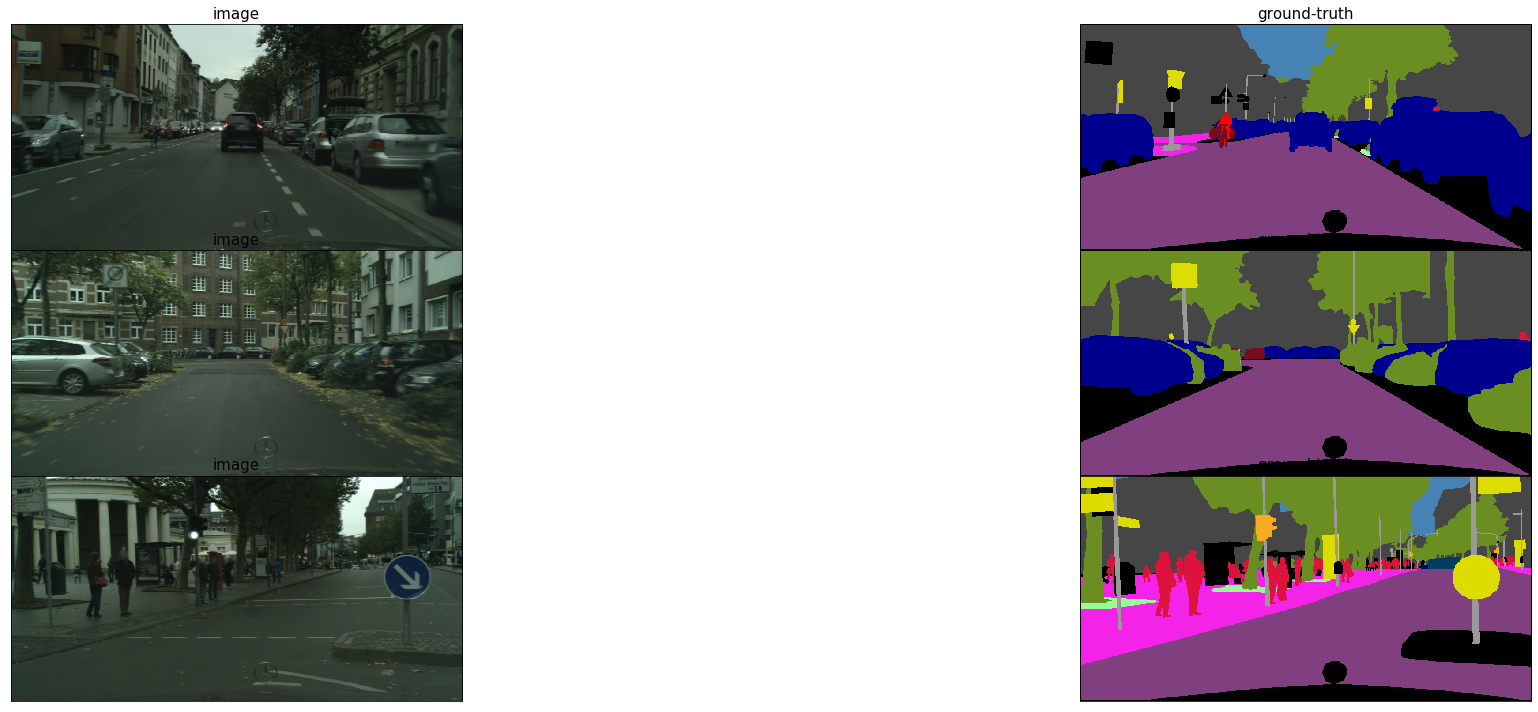

In [66]:
# Process:
image_show, predicted_show, gt_show = predict_and_postprocess(images = val_image_samples,
                                                              gt_labels = val_gt_samples)

# Plot:
fig = plot_images_inGrid(images=[image_show.numpy(), gt_show.numpy()], 
                         titles=["image", 'ground-truth'])
fig.show()


Seems like everything is working. 

## 6.4 - Callbacks:

Set up callbacks for the training process.

In [67]:
# Import the required library:
from customCallbacks_Keras import TensorBoard_ImageGrid_Callback

In [68]:
def postprocess_for_grid_callback(input_images, predicted_images, gt_images):
    # Convert the predicted logits into Categorical results:
    # for each pixel, we assign the class corresponding to the largest logit/probability.
    predicted_images = tf.math.argmax(predicted_images, axis= -1)
    predicted_images = tf.expand_dims(predicted_images, axis = -1)
    
    # Post Process the tensors for Visualisation:
    images_show, predicted_show, gt_show = postprocess_to_show_images(image=input_images,
                                                                     pred=predicted_images,
                                                                     gt=gt_images,
                                                                     one_hot=True,
                                                                     ratio=2)
    return images_show, predicted_show, gt_show 

## 7 - Training the FCN-8s model on the Dataset:

In [69]:
# Import the required library:
import collections
from customCallbacks_Keras import Simplified_LogCallback

In [70]:
# Set up Path Directory to Save the Model:
model_dir = os.path.join('.', 'models', 'FCN8s_Cityscapes')

# Set up the Metrics to Print:
metrics_to_print = collections.OrderedDict([("loss", "loss"), 
                                            ("v-loss", "val_loss"),
                                            ("acc", "acc"), 
                                            ("v-acc", "val_acc"),
                                            ("mIoU", "mIoU"), 
                                            ("v-mIoU", "val_mIoU")])

callbacks = [
    
    # Callback to interrupt the training if the validation loss/metric stops imrpoving for some amount of epochs:
    tf.keras.callbacks.EarlyStopping(monitor ='val_loss',
                                     patience = 8,
                                     restore_best_weights = True
                                    ),
    
    # Callback to log the graph, Losses and Metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir = model_dir,
                                    histogram_freq = 0,
                                    write_graph = True
                                  ),
    
    # Callback to save the model specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5),
    
    # Log the Callbacks:
    Simplified_LogCallback(metrics_dict = metrics_to_print,
                           nb_epochs = nb_epochs,
                           log_frequency= 10
                          ),
    
    # Callback to log some validation results as Image Grids into TensorBoard:
    TensorBoard_ImageGrid_Callback(log_dir = model_dir,
                                   input_images = val_image_samples,
                                   target_images= val_gt_samples,
                                   tag='FCN8s_Cityscapes_results',
                                   figsize=( 15, 15 ),
                                   grayscale=True,
                                   transpose=True,
                                   preprocess_fn=postprocess_for_grid_callback)
            ]


<Figure size 4500x4500 with 0 Axes>

In [71]:
# Define the optimiser:
# optimiser = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=0.1, clipvalue=0.5)
optimiser = tf.keras.optimizers.Adam()

# Compile the model:
fcn8s_model.compile(optimizer=optimiser,
                    loss= SegmentationLoss(from_logits=True),
                    metrics=[SegmentationAccuracy(), SegmentationMeanIoU(nb_classes=nb_classes)]
                   )

# fcn8s_model.compile(optimizer=optimiser,
#                     loss= SegmentationLoss2(layer),
#                     metrics=[SegmentationAccuracy(), SegmentationMeanIoU(nb_classes=nb_classes)]
#                    )

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


In [72]:
# running time calculation
start = timeit.default_timer()

In [73]:
history_fcn8s = fcn8s_model.fit(train_dataset,
                                epochs=nb_epochs,
                                steps_per_epoch=train_steps_per_epoch,
                                validation_data=val_dataset,
                                validation_steps=val_steps_per_epoch,
                                verbose=0,
                                callbacks=callbacks)

Training: start


D:\anaconda3\envs\Py37Work_TF2Alpha\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch  1/300: loss = 0.766; v-loss = 0.631; acc = 0.769; v-acc = 0.812; mIoU = 0.187; v-mIoU = 0.218
Epoch 11/300: loss = 0.363; v-loss = 0.334; acc = 0.889; v-acc = 0.898; mIoU = 0.379; v-mIoU = 0.386
Epoch 21/300: loss = 0.294; v-loss = 0.269; acc = 0.908; v-acc = 0.916; mIoU = 0.453; v-mIoU = 0.460
Epoch 31/300: loss = 0.278; v-loss = 0.275; acc = 0.913; v-acc = 0.915; mIoU = 0.476; v-mIoU = 0.495
Epoch 41/300: loss = 0.260; v-loss = 0.233; acc = 0.918; v-acc = 0.926; mIoU = 0.499; v-mIoU = 0.517
Epoch 51/300: loss = 0.260; v-loss = 0.219; acc = 0.918; v-acc = 0.931; mIoU = 0.511; v-mIoU = 0.544
Training: end


In [74]:
# Stop the timer:
stop = timeit.default_timer()
print('Time: {} Minutes'.format(round((stop - start)/60, 2)))
print('Time: {} hours'.format(round((stop - start)/3600, 2)))

Time: 311.27 Minutes
Time: 5.19 hours


## 8 - Plot the Results:

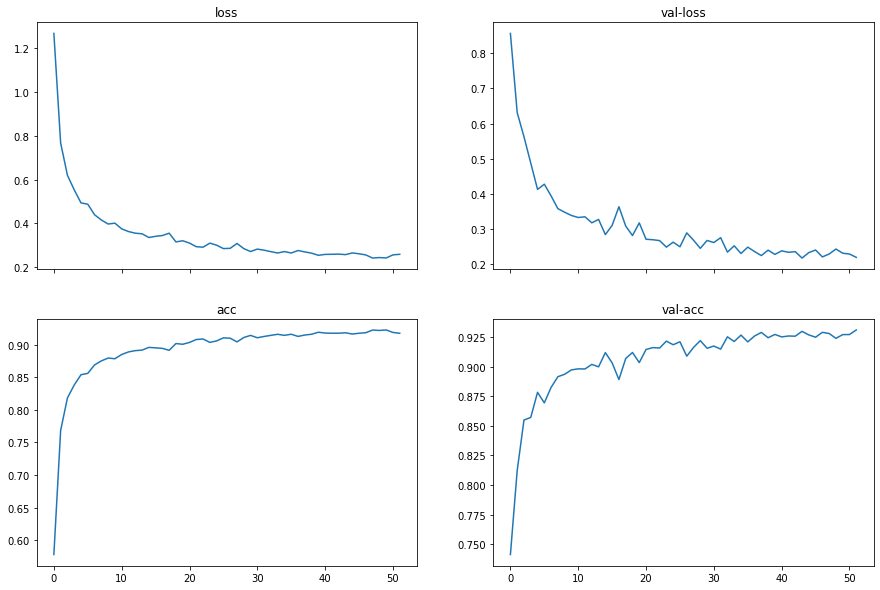

In [75]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")

ax[0, 0].plot(history_fcn8s.history['loss'])
ax[0, 1].plot(history_fcn8s.history['val_loss'])
ax[1, 0].plot(history_fcn8s.history['acc'])
ax[1, 1].plot(history_fcn8s.history['val_acc'])

D:\anaconda3\envs\Py37Work_TF2Alpha\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


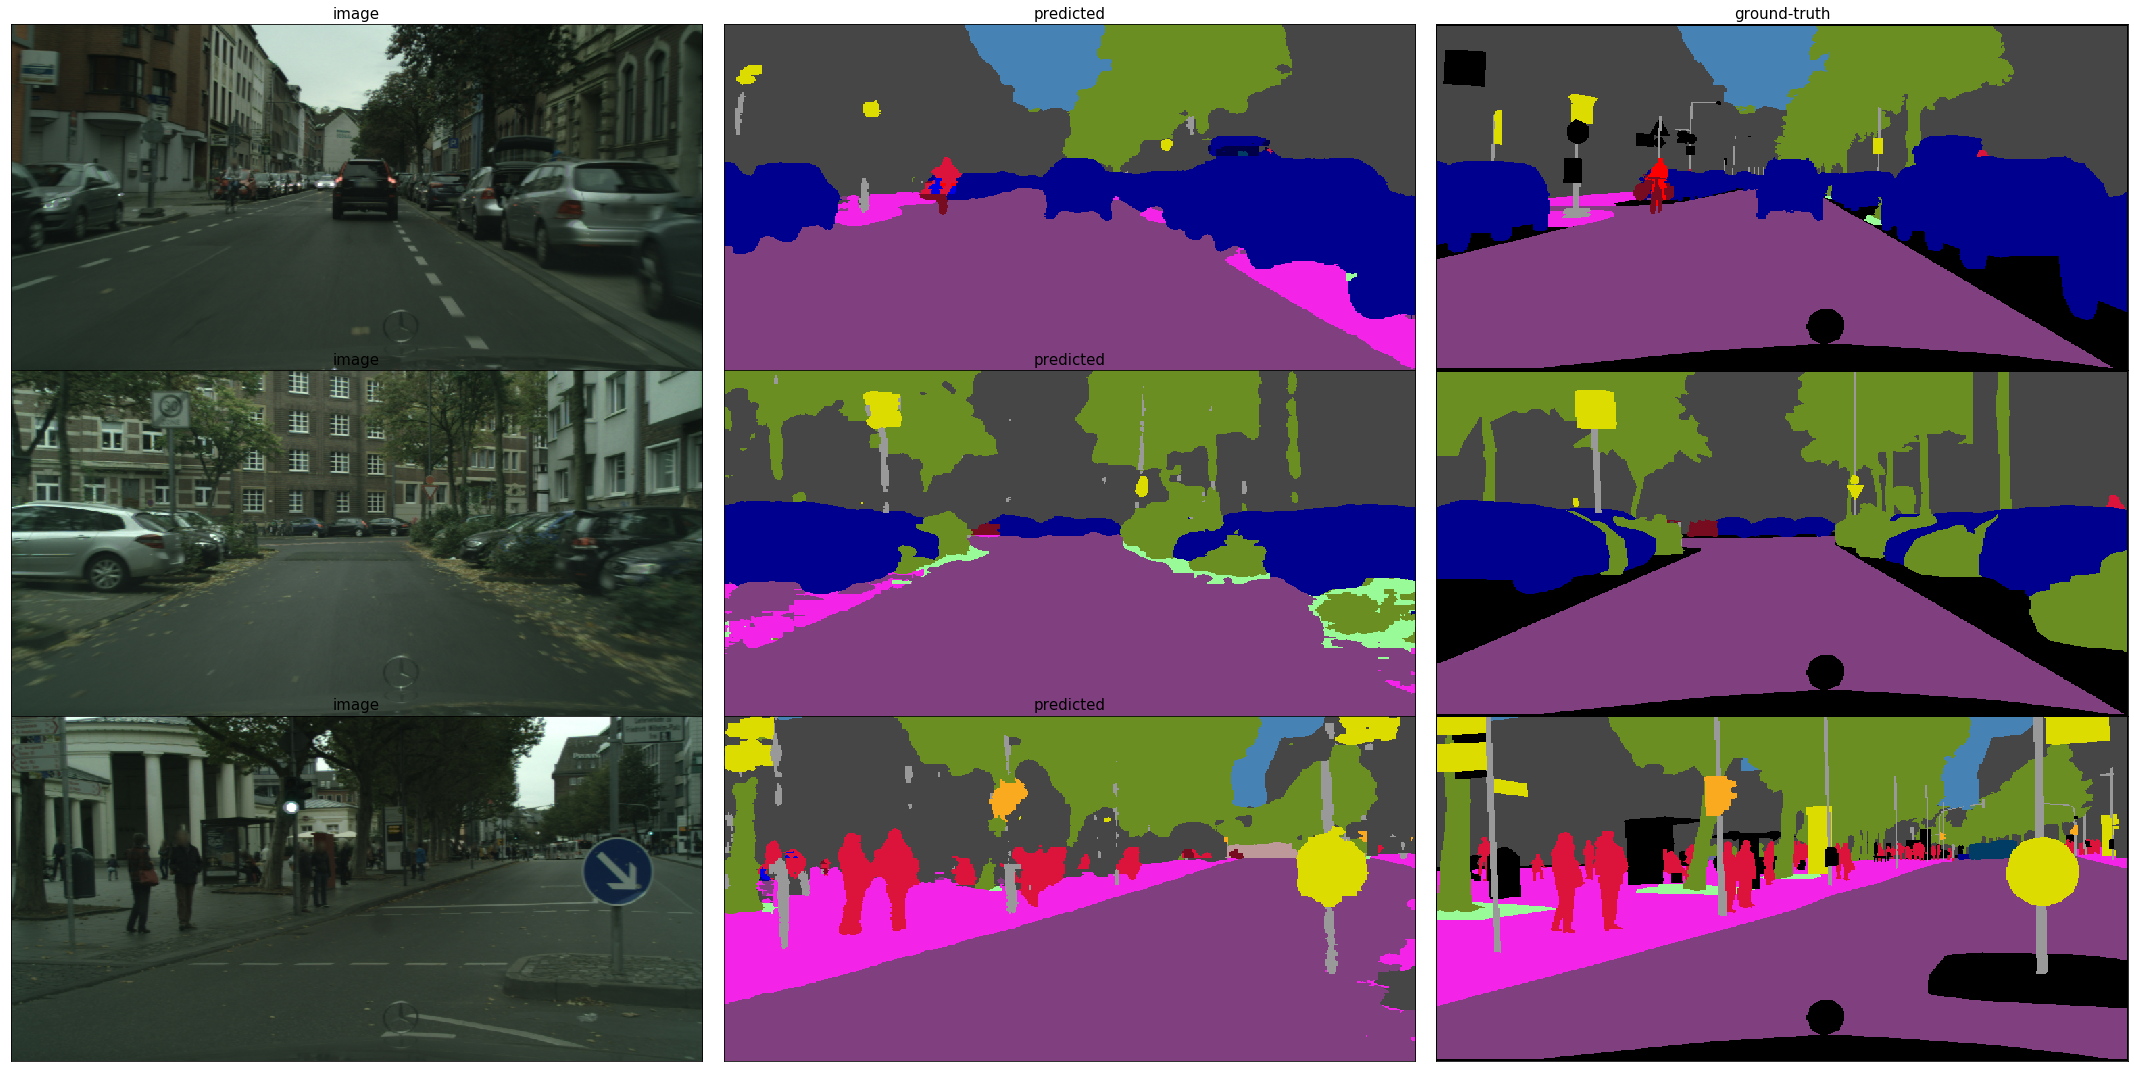

In [77]:
# Process:
image_show, predicted_show, gt_show = predict_and_postprocess(images = val_image_samples,
                                                              gt_labels = val_gt_samples)

# Plot:
fig = plot_images_inGrid(images=[image_show.numpy(), predicted_show.numpy(), gt_show.numpy()], 
                         titles=["image",'predicted', 'ground-truth'])
fig.show()


### Observation:

## 9 -

In [76]:
# <img src="Description Images/.png" width="750">

# Image Ref -> 

# <img src="Description Images/.png" width="750">

# Image Ref -> 